In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, BaselineOnly, SlopeOne
from surprise.model_selection import cross_validate


sns.set_style("darkgrid")

In [2]:
file_name_1 = r'..\data\combined_data_1.txt'
file_name_2 = r'..\data\combined_data_2.txt'
file_name_3 = r'..\data\combined_data_3.txt'
file_name_4 = r'..\data\combined_data_4.txt'


df1 = pd.read_csv(file_name_1, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [3]:
# df2 = pd.read_csv(file_name_2, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df3 = pd.read_csv(file_name_3, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df4 = pd.read_csv(file_name_4, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

# df2['Rating'] = df2['Rating'].astype(float)
# df3['Rating'] = df3['Rating'].astype(float)
# df4['Rating'] = df4['Rating'].astype(float)

# print('Dataset 2 shape: {}'.format(df2.shape))
# print('Dataset 3 shape: {}'.format(df3.shape))
# print('Dataset 4 shape: {}'.format(df4.shape))


In [3]:
# load less data for speed

df = df1
# df = df1.append(df2)
# df = df.append(df3)
# df = df.append(df4)

In [4]:
# 看一看数据形式

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


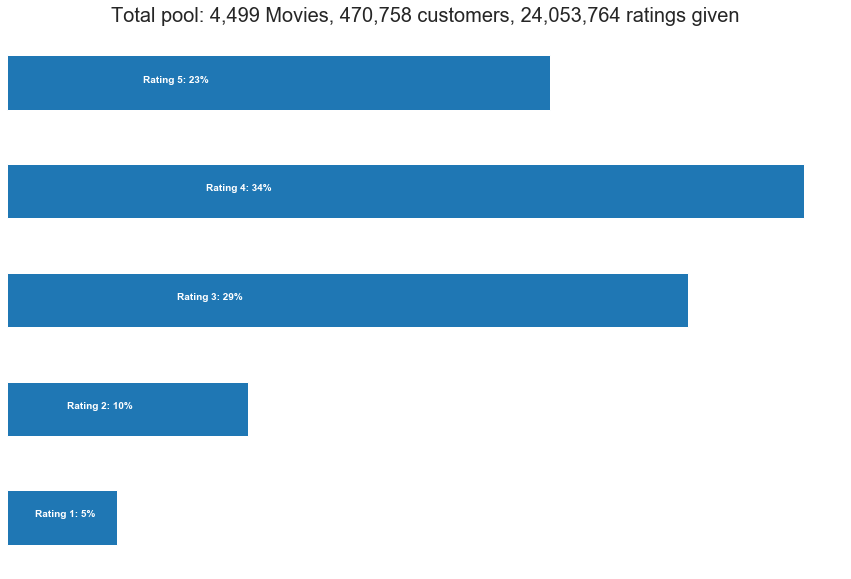

In [5]:
#查看数据分布

p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

plt.show()

In [4]:
# 数据格式转换
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])    

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [6]:
# 数据筛选，去除评分少的用户

f = ['count','mean']

# df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
# df_movie_summary.index = df_movie_summary.index.map(int)
# movie_benchmark = round(df_movie_summary['count'].quantile(0.75),0)
# drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

# print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.75),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 64.0


In [7]:
del df1, df_cust_summary, df_nan

In [8]:
print('Original Shape: {}'.format(df.shape))
# df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17050287, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
7019576    485279     4.0      1406
14079715   243736     4.0      2701
21145264  1558888     2.0      3954


In [9]:
# df_p = pd.pivot_table(df, values='Rating', index='Cust_Id', columns='Movie_Id')

# print(df_p.shape)

(118918, 4499)


In [14]:
# 使用筛选后的数据进行交叉验证
# 这里使用了第一个文件中的，用户打分数大于64的全部数据，大概120k条数据，共4499个电影
# 经过比较，baseline算法不论是计算速度还是准确率都很高，因此选用baseline

reader = Reader()
data_train = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

# 使用SVD算法
# algo = SVD()

# # 使用SlopeOne算法
# algo = SlopeOne()

# 使用Baseline算法
# ALS优化
bsl_options = {'method': 'als','n_epochs': 5,'reg_u': 12,'reg_i': 5}
# SGD优化
# bsl_options = {'method': 'sgd','n_epochs': 5}

algo = BaselineOnly(bsl_options=bsl_options)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9116  0.9118  0.9115  0.9117  0.0001  
MAE (testset)     0.7171  0.7173  0.7172  0.7172  0.0001  
Fit time          35.25   534.22  50.29   206.59  231.75  
Test time         125.97  124.12  119.19  123.09  2.86    


{'test_rmse': array([0.91164778, 0.91181416, 0.9115186 ]),
 'test_mae': array([0.71708809, 0.71732059, 0.71722235]),
 'fit_time': (35.25316095352173, 534.2246301174164, 50.289867639541626),
 'test_time': (125.9675829410553, 124.11938071250916, 119.19389152526855)}